In [200]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import time
from util.angle import *
from util.depth import *
from util.path import *
from util.visualizer import *
from util.object_dection import *
from util.selly_vision_api import *

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

#tensorrt model
loaded = tf.saved_model.load("./trt_fp16")
model = loaded.signatures["serving_default"]


ANGLE_CLASS = 18
ANGLE = angle_dict(ANGLE_CLASS)
ANGLE_IMG=angle_img(ANGLE, ANGLE_CLASS)

data = np.load("video_data.npz")
data = data["arr_0"]

img = data[:,0,:,:,:]
point_cloud = data[:,1,:,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


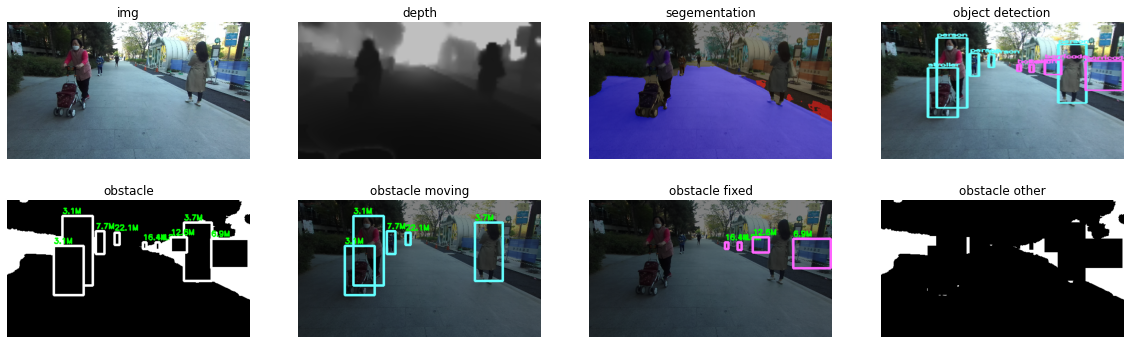

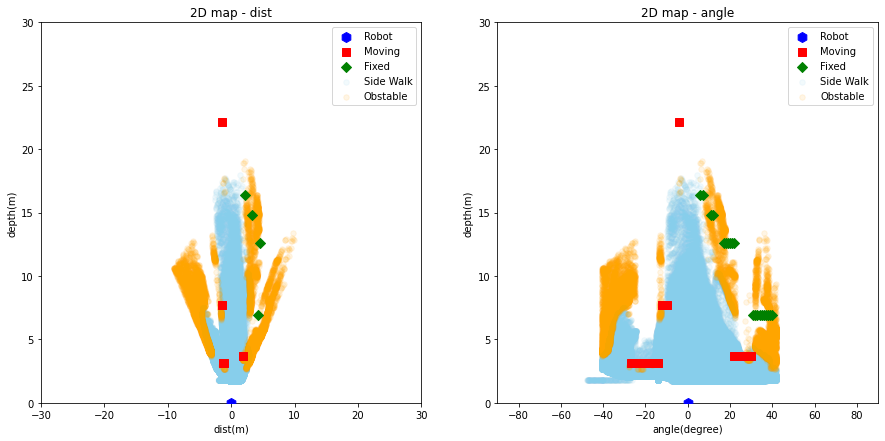

In [76]:
i = 141

#plt.imshow(selly_vision_redis(img[i], point_cloud[i])[0]/255)
visualize(model, img[i], point_cloud[i], 40, 40, ANGLE, ANGLE_CLASS, ANGLE_IMG)

In [213]:
def selly_vision_img(model, img, point_cloud, max_dist, fix_dist, ANGLE, ANGLE_CLASS):
    only_sidewalk = seg_predict(img.copy(),model)
    obj_frame, moving_object, fixed_object  = YOLO(img.copy())
    point = point_cloud.copy()
    point[200 :,:, 2][(point[200 :,:, 2] >5) & (only_sidewalk[200:,:,0] !=0)] = np.mean(point[:,:, 2][(point[:,:, 2]<2)& (only_sidewalk[:,:,0] !=0)])
    point[200 :,:, 1][(point[200 :,:, 1] >3) & (only_sidewalk[200:,:,0] !=0)] = np.mean(point[:,:, 1][(point[:,:, 1]<3)& (only_sidewalk[:,:,0] !=0)])
    point[200 :,:, 0][(point[200 :,:, 0] ==np.inf) | (np.abs(point[200 :,:, 0])>2)] = np.mean(point[200:,:, 0][point[200:,:, 0]<2])
    
    point[:,:, 2][point[:,:, 2]==np.inf] = 40
    only_sidewalk[(point[:,:,1] < -3) |  (point[:,:,1] ==np.inf)] = 0  #일정 높이 이상 segmetation 오차 제거

    depth = point2dist(point,  1)
    obstacle = np.ones_like(img)
    obstacle[only_sidewalk!=0] = 0
    
    angle = point.copy()
    angle[angle[:, :,2]==np.inf]=1
    angle = np.arctan((angle[:, :,0]/angle[:,:,2]
                            ))/np.pi * 180
    angle = angle[:,:, np.newaxis]
    angle= np.concatenate((angle,angle,angle) , axis = 2)
    
    moving_object_position, fixed_object_position =[] ,[]
    
    if len(moving_object):
        moving_object_position = object_angle(moving_object, angle.copy(), depth)
    if len(fixed_object):
        fixed_object_position = object_angle(fixed_object, angle.copy(), depth)
        
    for i in moving_object:
        obstacle[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = 0
    for i in fixed_object:
        obstacle[i[0][1] :i[1][1], i[0][0] : i[1][0], :] = 0    
        
    obstacle[(depth[:,:,0] > fix_dist) |(point[:,:,1] < -3) |  (point[:,:,1] ==np.inf)]=0 #일정 높이이상 장애물 제거

    angle_max = int(np.max(angle[:,:,0][angle[:,:,0]< 45]))
    angle_min = int(np.min(angle[:,:,0]))
    able_angle = [ i for i in range(angle_min, angle_max, 1) ] 
    able_angle_dict = {}
    for i in moving_object_position:
        if i[2] < max_dist:
            for j in range(int(i[0])-1, int(i[1])+1, 1):
                if j in able_angle:
                    able_angle.remove(j)

    for i in fixed_object_position:
        if i[2] < fix_dist:
            for j in range(int(i[0])-1, int(i[1])+1,1 ):
                if j in able_angle:
                    able_angle.remove(j)

    for i in able_angle:
        obs_angle = obstacle[(angle > i-1) & (angle < i+1) & (obstacle!=0)].shape[0]
        able_angle_dict[i] = obs_angle

    able_angle = sorted(able_angle_dict.items(), key =  lambda x : x[1])
    
    plt.imshow(obstacle)

    return moving_object_position, fixed_object_position, obstacle, able_angle

def object_angle(object_position, angle, depth):
    object_dist_array = []
    for i in object_position:
        cen_x = (i[1][0]-i[0][0])//6
        cen_y = (i[1][1]-i[0][1])//6
        obj_depth = depth[i[0][1] + cen_y : i[1][1] -cen_y , i[0][0] + cen_x: i[1][0]-cen_x , :]
        obj_angle = angle[i[0][1] : i[1][1], i[0][0] : i[1][0], :]
        min_range = np.min(obj_depth)
        max_range = min_range + 0.5
        obj_depth = depth[i[0][1]: i[1][1] +1 , i[0][0]: i[1][0]+1 , :]
        angle_min =  np.round(np.min(obj_angle[obj_angle<45]),1)
        angle_max =  np.round(np.max(obj_angle[obj_angle<45]),1)
        object_dist_array.append([angle_min, angle_max, np.round(min_range,1)])
    object_dist_array = np.array(object_dist_array)
    return object_dist_array

def object_dist(object_position, point_cloud, depth):
    object_dist_array = []
    for i in object_position:
        cen_x = (i[1][0]-i[0][0])//6
        cen_y = (i[1][1]-i[0][1])//6
        obj_depth = depth[i[0][1] + cen_y : i[1][1] -cen_y , i[0][0] + cen_x: i[1][0]-cen_x , :]
        obj_position = point_cloud[i[0][1]: i[1][1] +1 , i[0][0]: i[1][0]+1 , :]
        min_range = np.min(obj_depth)
        max_range = min_range + 0.5
        obj_depth = depth[i[0][1]: i[1][1] +1 , i[0][0]: i[1][0]+1 , :]
        x_min =  np.round(np.min(obj_position[:,:, 0][(obj_depth[:,:, 2] >= min_range) & (obj_depth[:,:, 2] <= max_range)]),1)
        x_max =  np.round(np.max(obj_position[:,:, 0][(obj_depth[:,:, 2] >= min_range) & (obj_depth[:,:, 2] <= max_range)]),1)
        object_dist_array.append([x_min, x_max, np.round(min_range,1)])
    object_dist_array = np.array(object_dist_array)
    return object_dist_array

0.07901263236999512


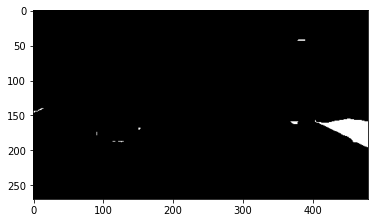

In [214]:
i =141
st = time.time()
moving_object_position, fixed_object_position, obstacle, obs_angle = selly_vision_img(model, img[i], point_cloud[i], 10, 5, ANGLE, ANGLE_CLASS)
print(time.time() - st)

[(-47, 0),
 (-46, 0),
 (-45, 0),
 (-44, 0),
 (-43, 0),
 (-42, 0),
 (-37, 0),
 (-36, 0),
 (-35, 0),
 (-34, 0),
 (-33, 0),
 (-32, 0),
 (-31, 0),
 (-30, 0),
 (-29, 0),
 (-8, 0),
 (-7, 0),
 (-6, 0),
 (-5, 0),
 (-4, 0),
 (-3, 0),
 (-2, 0),
 (-1, 0),
 (0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 0),
 (-38, 3),
 (-41, 33),
 (-39, 39),
 (32, 48),
 (-40, 69),
 (33, 114),
 (34, 243),
 (35, 477),
 (36, 687),
 (37, 918),
 (38, 1122),
 (39, 1341),
 (40, 1695)]

In [207]:
point = point_cloud[141].copy()
np.min(point[:,:,0]), np.max(point[:,:,0][point[:,:,0]!=np.inf])

(-19.113325, 31.365744)

In [7]:
pp = point_cloud[141].copy()
pp[pp[:, :,0]==np.inf]=1000
pp[pp[:, :,2]==np.inf]=1
pp = np.arctan((pp[:, :,0]/pp[:,:,2]
                     ))/np.pi * 180
pp = pp[:,:, np.newaxis]
pp= np.concatenate((pp,pp,pp) , axis = 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


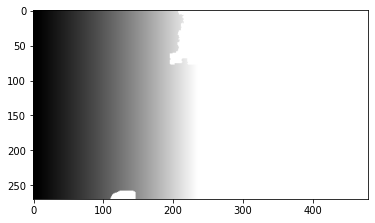

In [114]:
plt.imshow((pp+40)/40)

In [291]:
import os
sight_list =os.listdir("sight")
sight_list.sort()
i=0
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('sight.mp4', fourcc, 10.0, (2160,720))
while i<len(sight_list)-2:
    st = time.time()
    img = cv2.imread("sight/"+sight_list[i+1])
    out.write(img)
    print(time.time() - st)
    i+=1
out.release()

0.04145050048828125
0.025942087173461914
0.02433609962463379
0.02414536476135254
0.024256467819213867
0.02442193031311035
0.024381399154663086
0.02422022819519043
0.024418354034423828
0.024190902709960938
0.02439260482788086
0.02441263198852539
0.025377511978149414
0.02431321144104004
0.024089574813842773
0.02403736114501953
0.02403116226196289
0.02420210838317871
0.024307966232299805
0.02425241470336914
0.02430129051208496
0.02427816390991211
0.02411055564880371
0.024143218994140625
0.025564193725585938
0.024376630783081055
0.024253129959106445
0.024506092071533203
0.024331331253051758
0.024158716201782227
0.024013519287109375
0.024274826049804688
0.024123430252075195
0.02446126937866211
0.024236202239990234
0.024268150329589844
0.02519536018371582
0.02400684356689453
0.024106979370117188
0.024413585662841797
0.024142742156982422
0.0241239070892334
0.024019241333007812
0.024045467376708984
0.023876667022705078
0.023828744888305664
0.02384185791015625
0.023984909057617188
0.02519702911

KeyboardInterrupt: 